Задание - Обучите нейронную сеть любой архитектуры на каком-то производственном датасете. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.
Можно сегментацию по Северстали.

В конце, обязательно подвести вывод.


# Выводы

Пришлось использовать выборку в 25% из массива данных, поскольку при обработке всего массива возникала нехватка оперативной памяти и в Google Colab, и в Jupiter Notebook.
В трёхслойной нейросети на 10-й эпохе loss: 0.0582, accuracy: 0.9922, val_loss: 0.1517, val_accuracy: 0.9622. В пятислойной - loss: 0.1449, accuracy: 0.9666, val_loss: 0.2063, val_accuracy: 0.9351. В 13-слойной - loss: 0.5159, accuracy: 0.7948, val_loss: 0.5002, val_accuracy: 0.7994. Таким образом, видно, что с увеличением количества слоев растут потери и падает точность прогнозов модели на данных обучения и на новых данных. Вместе с тем в 13-слойной нейросети val_accuracy становится выше, чем accuracy, то есть нейросеть лучше работает с новыми данными, чем с обучающими.

ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [5]:
data = pd.read_csv('train.csv')

In [7]:
data = data.sample(frac=0.25)

In [8]:
data

,ImageId,ClassId,EncodedPixels
3268,76ff61cb4.jpg,3,84726 11 84961 32 85196 53 85430 75 85665 96 8...
303,0ae4f8a60.jpg,3,16851 46 17061 92 17317 92 17573 92 17829 92 1...
1849,4448b4286.jpg,3,158697 20 158928 45 159181 48 159435 50 159688...
6237,e006b532b.jpg,1,215512 9 215750 27 215989 45 216227 63 216474 ...
3252,76532309b.jpg,1,50604 3 50856 7 51107 12 51359 16 51610 21 518...
...,...,...,...
274,09c967630.jpg,3,283378 5 283624 14 283832 4 283871 21 284086 1...
371,0d51538b9.jpg,4,809 41 1064 122 1319 164 1574 165 1829 166 208...
185,06f52f4dd.jpg,3,49923 1 50179 2 50435 3 50691 4 50947 4 51203 ...
1467,3604dfc38.jpg,3,273281 11366 284673 179 284929 128 285185 77 2...


In [9]:
data.shape

(1774, 3)

# Разведочный анализ данных

ClassId
3    1290
4     220
1     214
2      50
Name: count, dtype: int64

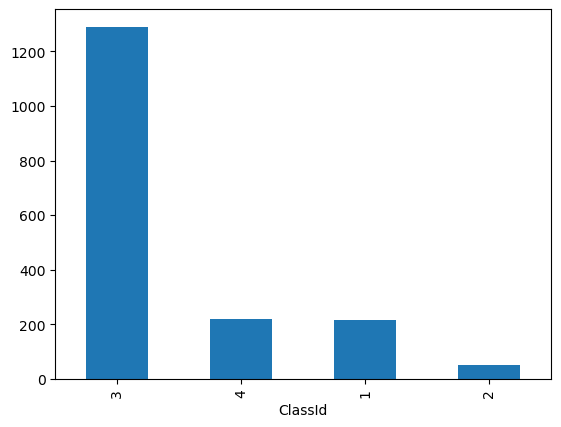

In [10]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [11]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [12]:
import cv2

In [13]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1774/1774 [00:12<00:00, 140.33it/s]


Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

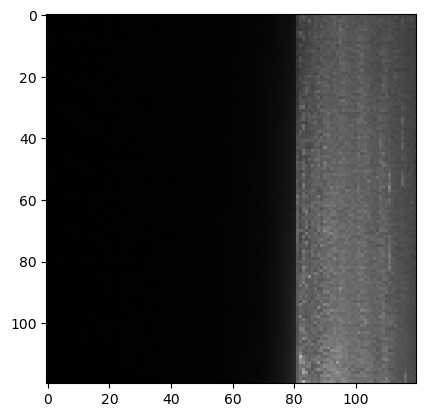

In [14]:
i = 15
plt.imshow(l1[i])

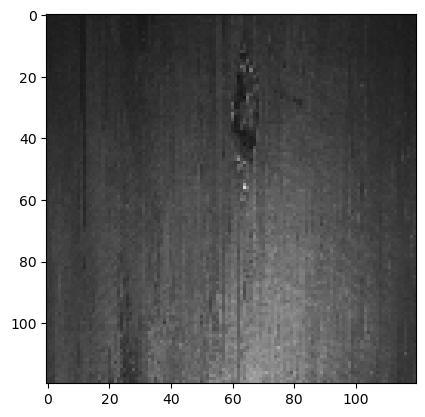

In [15]:
i = 16
plt.imshow(l1[i])

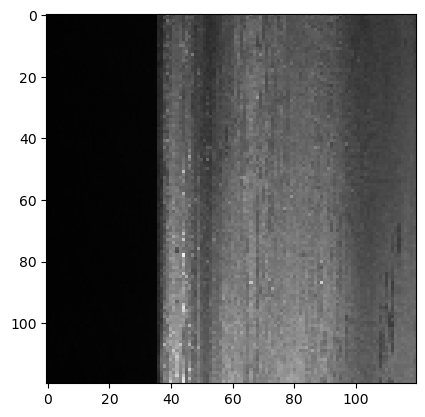

In [16]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [17]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [18]:
X.shape

(1774, 120, 120, 3)

In [19]:
y.shape

(1774,)

# Борьба с дисбалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [20]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [21]:
X.shape

(5160, 120, 120, 3)

In [22]:

y = to_categorical(y)

In [23]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [24]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [25]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (4128, 120, 120, 3)
x_test размер: (1032, 120, 120, 3)
y_train размер: (4128, 4)
y_test размер: (1032, 4)


# Построение нейронной сети  в 3 слоя и график обучения

In [26]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [27]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [28]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10


33/33 [==============================] - 16s 427ms/step - loss: 4.8817 - accuracy: 0.4440 - val_loss: 1.2155 - val_accuracy: 0.5669
Epoch 2/10
33/33 [==============================] - 13s 402ms/step - loss: 0.8294 - accuracy: 0.6516 - val_loss: 0.6683 - val_accuracy: 0.7500
Epoch 3/10
33/33 [==============================] - 13s 396ms/step - loss: 0.4904 - accuracy: 0.8430 - val_loss: 0.4441 - val_accuracy: 0.8411
Epoch 4/10
33/33 [==============================] - 12s 373ms/step - loss: 0.2973 - accuracy: 0.9230 - val_loss: 0.2971 - val_accuracy: 0.9254
Epoch 5/10
33/33 [==============================] - 12s 377ms/step - loss: 0.1987 - accuracy: 0.9598 - val_loss: 0.2690 - val_accuracy: 0.9157
Epoch 6/10
33/33 [==============================] - 12s 376ms/step - loss: 0.1429 - accuracy: 0.9741 - val_loss: 0.2525 - val_accuracy: 0.9089
Epoch 7/10
33/33 [==============================] - 12s 376ms/step - loss: 0.1061 - accuracy: 0.9845 - val_loss: 0.1971 - val_accuracy: 0.94

<Axes: title={'center': 'Loss curve'}>

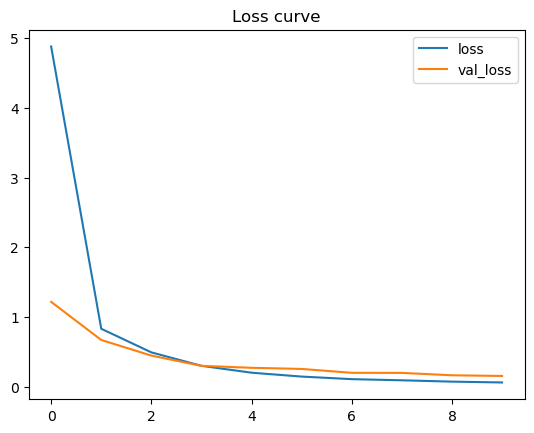

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

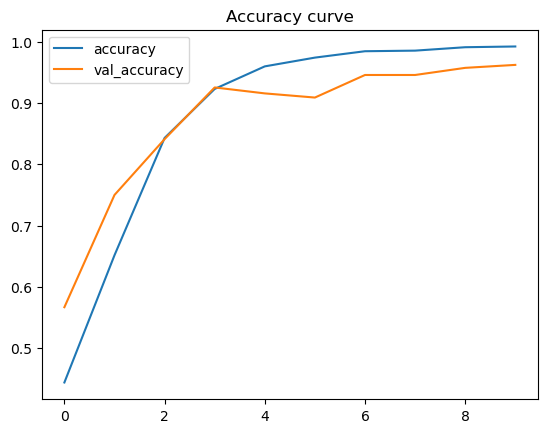

In [30]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети  в 5 слоев

In [31]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))


In [32]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [33]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
33/33 [==============================] - 26s 751ms/step - loss: 2.3464 - accuracy: 0.4162 - val_loss: 0.9954 - val_accuracy: 0.5417
Epoch 2/10
33/33 [==============================] - 25s 752ms/step - loss: 0.8682 - accuracy: 0.6182 - val_loss: 0.8017 - val_accuracy: 0.6405
Epoch 3/10
33/33 [==============================] - 20s 614ms/step - loss: 0.7036 - accuracy: 0.7117 - val_loss: 0.6706 - val_accuracy: 0.7248
Epoch 4/10
33/33 [==============================] - 20s 614ms/step - loss: 0.5636 - accuracy: 0.7980 - val_loss: 0.5449 - val_accuracy: 0.7868
Epoch 5/10
33/33 [==============================] - 20s 591ms/step - loss: 0.4432 - accuracy: 0.8493 - val_loss: 0.4392 - val_accuracy: 0.8450
Epoch 6/10
33/33 [==============================] - 19s 588ms/step - loss: 0.3488 - accuracy: 0.8866 - val_loss: 0.3626 - val_accuracy: 0.8857
Epoch 7/10
33/33 [==============================] - 20s 605ms/step - loss: 0.2739 - accuracy: 0.9215 - val_loss: 0.3050 - val_accuracy: 0.9041

<Axes: title={'center': 'Loss curve'}>

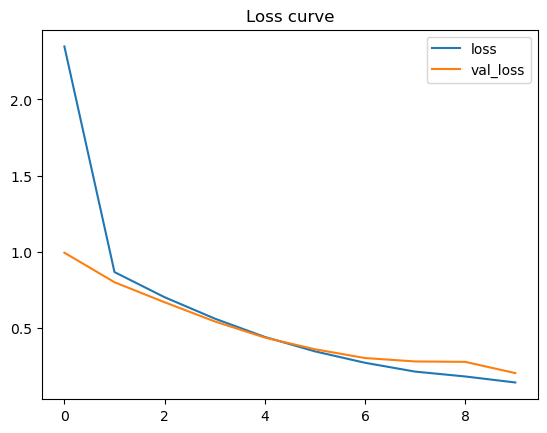

In [34]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

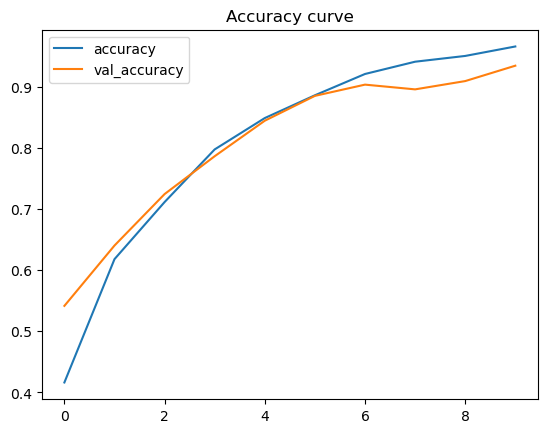

In [35]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети в 13 слоев и обучение

In [36]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [37]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [38]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [39]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
33/33 [==============================] - 34s 884ms/step - loss: 1.2625 - accuracy: 0.3953 - val_loss: 1.0299 - val_accuracy: 0.5407
Epoch 2/10
33/33 [==============================] - 27s 829ms/step - loss: 0.9749 - accuracy: 0.5550 - val_loss: 0.9461 - val_accuracy: 0.5862
Epoch 3/10
33/33 [==============================] - 25s 773ms/step - loss: 0.8923 - accuracy: 0.6078 - val_loss: 0.9204 - val_accuracy: 0.6114
Epoch 4/10
33/33 [==============================] - 26s 777ms/step - loss: 0.8332 - accuracy: 0.6344 - val_loss: 0.7926 - val_accuracy: 0.6589
Epoch 5/10
33/33 [==============================] - 26s 776ms/step - loss: 0.7830 - accuracy: 0.6657 - val_loss: 0.7522 - val_accuracy: 0.7054
Epoch 6/10
33/33 [==============================] - 26s 775ms/step - loss: 0.7299 - accuracy: 0.6921 - val_loss: 0.7291 - val_accuracy: 0.6957
Epoch 7/10
33/33 [==============================] - 26s 775ms/step - loss: 0.6873 - accuracy: 0.7250 - val_loss: 0.6455 - val_accuracy: 0.7219

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

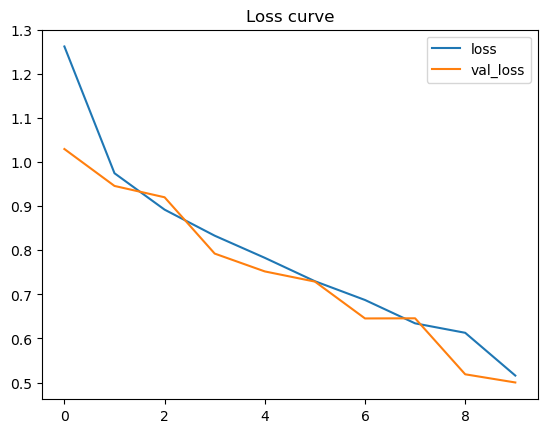

In [40]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

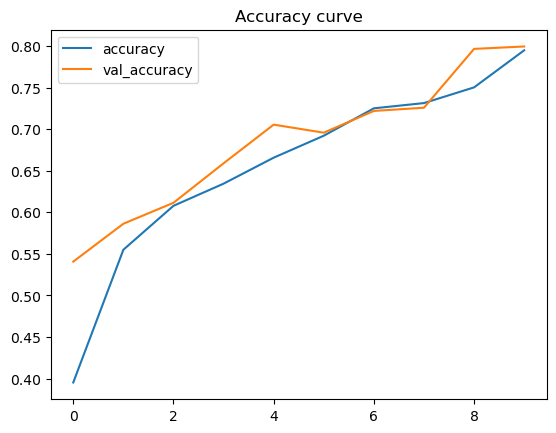

In [41]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [42]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

33/33 [==============================] - 2s 62ms/step - loss: 0.5002 - accuracy: 0.7994
[+] Accuracy: 79.94%


In [43]:
from keras.models import Model
model.save('my_model_steel.keras')

In [45]:
from keras.models import load_model

loaded_model = load_model('my_model_steel.keras')


# Архитектура созданной нейронной сети

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)         

# Тестирование на новых примерах

In [47]:
l2[:3]

[3, 3, 3]

In [48]:
X= np.array(l1[:3])
X = X/255

y = encoder.fit_transform(l2[:3])
y = np.array(y)

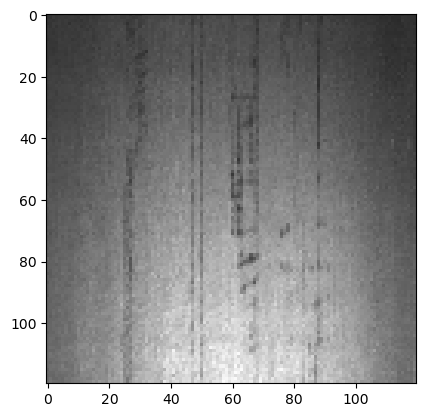

In [49]:
plt.imshow(l1[0]);

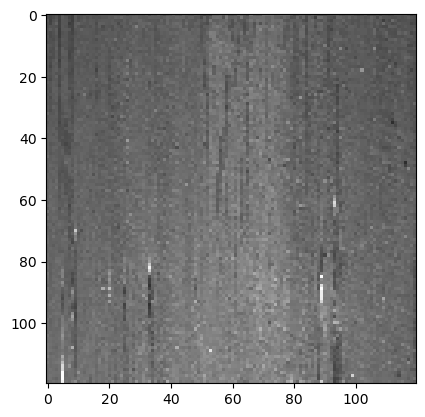

In [50]:
plt.imshow(l1[1]);

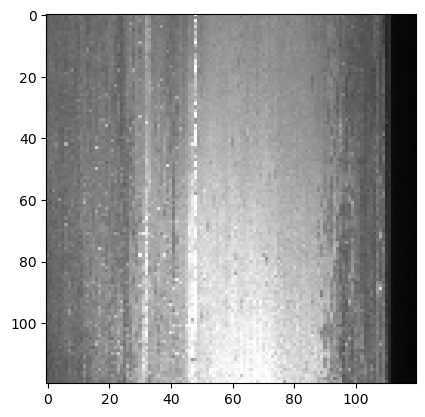

In [51]:
plt.imshow(l1[2]);

In [52]:
y =  to_categorical(y)
y

array([[1.],
       [1.],
       [1.]], dtype=float32)

In [53]:

predictions = model.predict(X)
predictions

1/1 [==============================] - 0s 190ms/step


array([[3.19496095e-02, 1.08605964e-04, 1.82568535e-01, 7.85373271e-01],
       [8.00238177e-02, 1.17361604e-03, 1.97350785e-01, 7.21451819e-01],
       [2.54995227e-01, 8.23271112e-05, 7.32105136e-01, 1.28173782e-02]],
      dtype=float32)

Здесь три эксперимента, где мы видим, что тест № 2 был с меткой 3, но неверно идентифицировался как метка 1.

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)         

# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.